# Project TMA4212 - Rubber Vulcanization
## Task 1
We want to model the chemical process of vulcanization using finite difference methods.

Our parameters of interest are:
- $T(\mathbf{x},t)$: temperature [K]
- $\alpha(\mathbf{x},t)$: degree of cure where 0 is uncured and 1 is fully cured

Here $\mathbf{x} $ is the 2d position vector $(x,y)$ in $\Omega$.

The temperature in our model is given by the heat equation:
$$
\rho c_p \frac{\partial T}{\partial t} = k \Delta T + \rho H_r \frac{\partial \alpha}{\partial t} \quad \text{on } \Omega
$$ 
with the boundary condition where $T_m$ is the mold temperature
$$
-k \frac{\partial T}{\partial n} = h(T - T_m) \quad \text{on } \partial\Omega
$$.

The degree of cure $\alpha$ is described by the Arrhenius Law.
$$
\frac{\partial \alpha}{\partial t} = \begin{cases} 0 & T \le T_s \\ A \exp\left(-\frac{E}{RT}\right) \alpha^m (1-\alpha)^n & T > T_s \end{cases}
$$.

To get a dimensionless model, we rewrite the model with these scalings:
- Temperature: $u = \frac{T - T_m}{T_m - T_0}, \qquad u(\mathbf{x}^*,0)=-1$
- Space: $\mathbf{x}^* = \mathbf{x} / L$
- Time: $t^* = t / t_{\mathrm{diff}}$, where $t_{\mathrm{diff}} = \frac{\rho c_p L^2}{k}$

where L is a representative size for the rubber object, and $T_0$ is the initial temperature.

Substituting the dimensionless scaling, $T = T_m + u(T_m - T_0)$, $\mathbf{x} = L\, \mathbf{x}^*$, $t = t_{\mathrm{diff}}\, t^*$, into the differential operators we get:

$$
\frac{\partial T}{\partial t} = \frac{T_m - T_0}{t_{\mathrm{diff}}} \frac{\partial u}{\partial t^*}, \qquad \Delta T = \frac{T_m - T_0}{L^2} \Delta^* u
$$

Plugging the operators and using $t_{\mathrm{diff}} = \frac{\rho c_p L^2}{k}$  gives us:
$$
\frac{\partial u}{\partial t^*} = \Delta^* u + \frac{H_r}{c_p(T_m - T_0)} \frac{\partial \alpha}{\partial t^*} 
$$

Substituting the same scaling in the boundary condition, we get:
$$
-k \frac{T_m - T_0}{L} \frac{\partial u}{\partial n^*} = h \cdot u (T_m - T_0)\\


- k \frac{\partial u}{\partial n^*} = hL  u
$$.

The Arrhenius Law is now,
$$
\frac{\partial \alpha}{\partial t^*} = \begin{cases} 0 & u \le u_s \\  t_{\mathrm{diff}} \cdot A \exp\!\left(-\frac{E}{R(T_m + u(T_m - T_0))}\right) \alpha^m (1-\alpha)^n & u > u_s \end{cases}
$$
where $u_s = (T_s - T_m) / (T_m - T_0)$.


In these equations we can identify several dimensionless parameters:
- Biot Number: $\mathrm{Bi} = \frac{hL}{k}$
- Heat ratio parameter: $\delta = \frac{H_r}{c_p(T_m - T_0)}$
- Damköhler number: $\mathrm{Da} = t_{\mathrm{diff}} \cdot A$ 
- Dimensionless energy: $E^* = \frac{E}{R T_m}$ 
- Dimensionless temperature: $\theta = \frac{T_m - T_0}{T_m}$


Using these dimensionless parameters together with our scaling parameters, we obtain the equations we will use in the rest of our project:
$$
\frac{\partial u}{\partial t} = \Delta u + \delta \frac{\partial \alpha}{\partial t} \quad \text{on } [0,1]^2 \\
-\frac{\partial u}{\partial n} = \mathrm{Bi} \cdot u \quad \text{on } \partial\Omega \\
\frac{\partial \alpha}{\partial t} = \begin{cases} 0 & u \le u_s \\ \mathrm{Da} \exp\!\left(\frac{-E^*}{1 + \theta u}\right) \alpha^m (1-\alpha)^n & u > u_s \end{cases} \\
u(\mathbf{x}^*,0)=-1
$$

## Task 2

In [47]:
%matplotlib inline
import numpy as np
import scipy.sparse as sparse             # Sparse matrices
from scipy.sparse.linalg import spsolve   # Linear solver for sparse matrices
import matplotlib.pyplot as plt
import pandas as pd  
newparams = {'figure.figsize': (10.0, 5.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 12}
plt.rcParams.update(newparams)

In [48]:
# Given parameters 
rho = 1100          # density [kg/m^3]
c_p = 1900          # heat capacity [J/(kg K)]
k   = 0.2           # thermal conductivity [W/(m K)]
H_r = 2.5e5         # total reaction heat [J/kg]
h   = 200           # heat transfer coefficient [W/(m^2 K)]

A_pre = 5e5         # pre-exponential factor [1/s]
E_act = 8.0e4       # activation energy [J/mol]
R_gas = 8.314       # gas constant [J/(mol K)]
m     = 1.2         # reaction exponent
n     = 1.8         # reaction exponent
T_s   = 393         # threshold temperature for curing [K]

# Domain and initial/boundary conditions
L   = 0.02          # side length of square domain [m]
T_0 = 300           # initial temperature [K]
T_m = 443           # mold temperature [K]
u_s = (T_s - T_m) / (T_m - T_0)  # scaled threshold temperature

# Diffusion time scale
t_diff = rho * c_p * L**2 / k

# Dimensionless parameters
Bi    = h * L / k                       # Biot number
delta = H_r / (c_p * (T_m - T_0))      # reaction heat ratio
Da    = t_diff * A_pre                  # Damköhler number
Estar = E_act / (R_gas * T_m)          # dimensionless  energy
theta = (T_m - T_0) / T_m             # temperature ratio

In [ ]:
def laplacian_robin(N, Bi):
    """
    Build the 2D Laplacian matrix with Robin BCs: -du/dn = Bi * u with use of ghost points.
    For example, at the left boundary (i=0), the ghost point u_{-1,j} is expressed as u_{1,j} - 2h*Bi*u_{0,j}.
    This is plugged into the standard 5-point stencil, modifying the center coefficients and right coefficient.
    """
    h = 1.0 / N         # step size
    Np = N + 1          # number of points per direction
    Ntot = Np * Np      # total unknowns

    # Convert grid index to flat index
    def idx(i, j):
        return j * Np + i

    # Construct a sparse A-matrix
    A = sparse.lil_matrix((Ntot, Ntot))
    
    # Loop over all grid points and fill in the stencil, modifying for Robin BCs at boundaries
    for j in range(Np):
        for i in range(Np):
            k = idx(i, j)

            # Determine which boundaries this point is on
            on_left   = (i == 0)
            on_right  = (i == N)
            on_bottom = (j == 0)
            on_top    = (j == N)

            center = -4.0  # standard 5-point stencil center coefficient

            # Boundary at x
            if on_left:  # If on the left boundary
                A[k, idx(1, j)] += 2.0        # itself + ghost
                center -= 2.0 * h * Bi        # extra diagonal from ghost
        
            elif on_right:                      # If on the right boundary
                A[k, idx(N-1, j)] += 2.0      # itself + ghost
                center -= 2.0 * h * Bi        # extra diagonal from ghost

            else:
                A[k, idx(i-1, j)] += 1.0      # normal left neighbor
                A[k, idx(i+1, j)] += 1.0      # normal right neighbor

            # Boundary at y
            if on_bottom:                     # if on the bottom boundary
                A[k, idx(i, 1)] += 2.0        # itself + ghost
                center -= 2.0 * h * Bi        # extra diagonal from ghost
            elif on_top:                        # if on the top boundary
                A[k, idx(i, N-1)] += 2.0      # itself + ghost
                center -= 2.0 * h * Bi        # extra diagonal from ghost

            else:
                A[k, idx(i, j-1)] += 1.0      # normal bottom neighbor
                A[k, idx(i, j+1)] += 1.0      # normal top neighbor

            A[k, k] = center                  # Set the diagonal entry

    A = A / h**2

    return A.tocsr()                          # Convert to CSR format 

def forward_euler(u0, A, dt):
    """
    Perform one forward Euler step: u1 = u0 + dt * A * u0. 
    We chose to use FE as discretization in time since it is simple and allows us to easily analyze stability by varying dt.
    """
    return u0 + dt * A.dot(u0)

def solve_heat_equation(A, u0, dt, num_steps):
    """
    Solve the heat equation du/dt = A*u using forward Euler.
    """
    u = u0.copy()
    for step in range(1, num_steps + 1):
        u = forward_euler(u, A, dt)
    
    return u

### Consistency 

Given our 5-point discretization with Forward Euler, we get the following scheme for our interior points:

$$
\frac{U_{i,j}^{n+1} -U_{i,j}^{n}}{\Delta t} = \frac{U_{i+1,j}^{n} + U_{i-1,j}^{n} + U_{i,j+1}^{n} + U_{i,j-1}^{n} - 4 U_{i,j}^{n}}{h^2} 
\tag1 
$$
$$
U_{i,j}^{n+1} = (I + \Delta t A) \cdot U_{i,j}^n 
\tag2

$$

To find the truncation error, we first Taylor expand time and space respectively:

**Time:**

$$
\frac{u^{n+1} - u^n}{\Delta t} = u_t + \frac{\Delta t}{2}\, u_{tt} + O(\Delta t^2)
$$

**Space:** 

$$
u_{i \pm 1, j} = u \pm h\, u_x + \frac{h^2}{2}\, u_{xx} \pm \frac{h^3}{6}\, u_{xxx} + \frac{h^4}{24}\, u_{xxxx} + O(h^5)
$$

$$
u_{i, j \pm 1} = u \pm h\, u_y + \frac{h^2}{2}\, u_{yy} \pm \frac{h^3}{6}\, u_{yyy} + \frac{h^4}{24}\, u_{yyyy} + O(h^5)
$$

If we so plug this into our scheme, we see that odd terms cancel out:
$$
\frac{u_{i+1,j} + u_{i-1,j} + u_{i,j+1} + u_{i,j-1} - 4 u}{h^2} = (u_{xx}+u_{yy})+ \frac{h^2}{12} (u_{xxxx}+ u_{yyyy})+O(h^4)
$$

Combining this with $ u_t = u_{xx} + u_{yy} $, we get the truncation error:

$$
\tau = \frac{\Delta t}{2} u_{tt} + \frac{h^2}{12} (u_{xxxx}+u_{yyyy}) + O(\Delta t^2+h^4)
$$

Since $\tau \rightarrow 0$ when $h, \Delta t \rightarrow 0$, our scheme is consistent with first-order in time and second-order in space.

**Remark:** For the Robin boundary condition, we use a ghost point with central differences such that for example for the left boundary we have the following scheme:
$$
\frac{U_{0,j}^{n+1} -U_{0,j}^{n}}{\Delta t} =\frac{2U_{1,j} + U_{0,j+1} + U_{0,j-1} - (4+2h Bi) U_{0,j}}{h^2} 
$$
If we so Taylor expand $u_{1,j}$ and $u_{0,j\pm 1}$ at $(0, y_j)$ and plug into the scheme, we get:

$$
\frac{2u_{1,j} + u_{0,j+1} + u_{0,j-1} - (4+2h\,\mathrm{Bi})\, u}{h^2} = \frac{2(u_x - \mathrm{Bi}\, u)}{h} + (u_{xx}+u_{yy}) + \frac{h}{3}\, u_{xxx} + \frac{h^2}{12}(u_{xxxx}+u_{yyyy}) + O(h^3)
$$

Using the Robin BC, $u_x = \mathrm{Bi}\, u$, at the left boundary, the first term vanishes and we get the truncation error:

$$
\tau_{\text{bound}} = \frac{\Delta t}{2}\, u_{tt} + \frac{h}{3}\, u_{xxx} + \frac{h^2}{12}(u_{xxxx}+u_{yyyy}) + O(\Delta t^2 + h^3)
$$

The local truncation error at boundary points is $O(\Delta t + h)$, one order lower in space than the interior. However, since these errors are confined to a boundary layer of width $h$, their contribution to the global error is $O(h) \cdot O(h) = O(h^2)$, so the overall convergence remains second-order in space.

### Stability Analysis
To analyze the stability of our interior scheme, we use the Von Neumann stability analysis. We assume a solution of the form:
$$U_{i,j}^n = \xi ^n e^{i \beta_x i h + i \beta_y j h}$$
where $\xi$ is the amplification factor, and $\beta_x, \beta_y$ are the wave numbers in the $x$ and $y$ directions respectively. Plugging this into our $\text{(1)}$ and dividing by the common factor $\xi^n e^{i \beta_x i h + i \beta_y j h}$, we get:
$$\xi = 1 + \frac{\Delta t}{h^2} (e^{i \beta_x h} + e^{-i \beta_x h} + e^{i \beta_y h} + e^{-i \beta_y h} - 4)$$
which simplifies to:
$$
\xi = 1 - 4 \frac{\Delta t}{h^2} \left( \sin^2\left(\frac{\beta_x h}{2}\right) + \sin^2\left(\frac{\beta_y h}{2}\right) \right)
$$

To ensure stability, we need $|\xi| \le 1$ for all $\beta_x, \beta_y$. As we can see, $\xi \le 1$ is always satisfied, therefore we only need to ensure that $\xi \ge -1$. Worst case, $\sin^2\left(\frac{\beta_x h}{2}\right)= \sin^2\left(\frac{\beta_y h}{2}\right)=1  $, we get the following condition:
$$
1 - 4 \frac{\Delta t}{h^2} \cdot 2 \ge -1 \\
\Delta t \le \frac{h^2}{4}
$$
However, the Von Neumann analysis only applies to the interior stencil. To account for the Robin boundary, we use the Gershgorin circle theorem on the matrix $A$ in equation (2). At a corner point, e.g. $(0,0)$, the ghost point substitution is applied in both $x$ and $y$, giving a first row of $A$:

$$
A[0, :] = \frac{1}{h^2}\Big[-(4 + 4h\,\mathrm{Bi}),\; 2,\; 0,\; \dots,\; 0,\; 2,\; 0,\; \dots,\; 0\Big]
$$

To ensure stability we need:

$$
|1+\Delta t \lambda_{\min}| \le 1
$$

By Gershgorin, $\lambda_{\min} \geq \min_i \left( a_{ii} - R_i \right)$  where $R_i = \sum_{j \neq i} |a_{ij}|$. The most restrictive row is the corner, where $a_{00} = -(4+4h\,\mathrm{Bi})/h^2$ and $R_0 = 4/h^2$, giving:

$$
|\lambda_{\min}| \le \frac{8 + 4h\,\mathrm{Bi}}{h^2}
$$

Plugging this into the stability condition we get:

$$
\Delta t \le \frac{2h^2}{8 + 4h\,\mathrm{Bi}} = \frac{h^2}{4 + 2h\,\mathrm{Bi}}
$$

This bound is even stricter than the bound found with Von Neumann analysis.

### Convergence

By the Lax equivalence theorem, our scheme is convergent by being consistent and stable. 

To verify this numerically, we compute solutions for different grids $N = 10, 20, 40, 80, 160$ and compare to a reference solution of $N=320$ with $\infty$-norm. We evaluate at $t^*=0.05$ where the solution hasn´t reached steady state yet.  We fix $ \Delta t $ safely below the stability limit with $\Delta t = 0.1 h^2$. From the plot below we observe that the error follows the reference of $O(h^2)$


We also demonstrate instability by comparing the norm of the solution for the CFL numbers, $C=\frac{\Delta t }{h^2}$, found in the Von Neumann analysis. The stability-plot shows that the scheme is only stable for the CFL number found from the boundary stencil.


         h         error    rate
----------------------------------
    0.1000    7.4673e-03       —
    0.0500    1.8483e-03    2.01
    0.0250    4.5582e-04    2.02
    0.0125    1.0848e-04    2.07
    0.0063    2.1694e-05    2.32


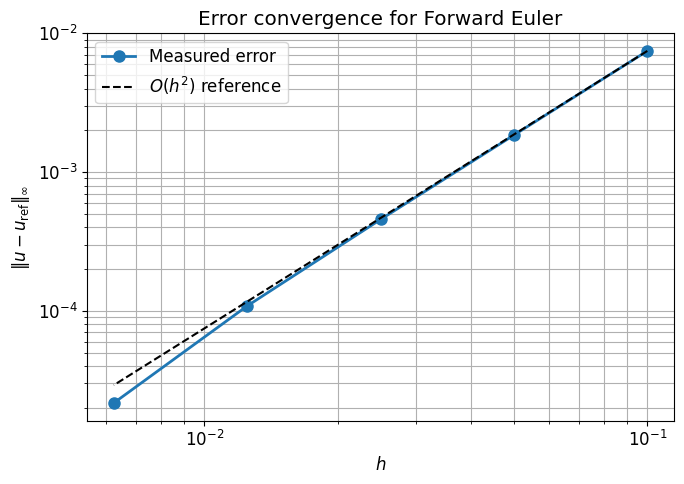

In [ ]:
Ns_conv = [10, 20, 40, 80, 160]
N_ref = 320
t_eval = 0.05          
C_dt = 0.10            

# Reference solution on fine grid

h_ref = 1.0 / N_ref
dt_ref = C_dt * h_ref**2
steps_ref = int(round(t_eval / dt_ref))
A_ref = laplacian_robin(N_ref, Bi)
u0_ref = -np.ones((N_ref + 1)**2)
u_ref = solve_heat_equation(A_ref, u0_ref, dt_ref, steps_ref)
U_ref = u_ref.reshape((N_ref + 1, N_ref + 1))


errors = []
hs_list = []
for Ni in Ns_conv:
    hi = 1.0 / Ni
    dti = C_dt * hi**2
    steps_i = int(round(t_eval / dti))
    Ai = laplacian_robin(Ni, Bi)
    u0i = -np.ones((Ni + 1)**2)
    ui = solve_heat_equation(Ai, u0i, dti, steps_i)
    Ui = ui.reshape((Ni + 1, Ni + 1))
    ratio = N_ref // Ni
    U_ref_coarse = U_ref[::ratio, ::ratio]
    err = np.max(np.abs(Ui - U_ref_coarse))
    errors.append(err)
    hs_list.append(hi)


hs_arr = np.array(hs_list)
errors_arr = np.array(errors)
rates = np.log(errors_arr[:-1] / errors_arr[1:]) / np.log(hs_arr[:-1] / hs_arr[1:])

# Table
print(f"\n{'h':>10s}  {'error':>12s}  {'rate':>6s}")
print("-" * 34)
for i, (hi, ei) in enumerate(zip(hs_arr, errors_arr)):
    rate_str = f"{rates[i-1]:.2f}" if i > 0 else "  —"
    print(f"{hi:10.4f}  {ei:12.4e}  {rate_str:>6s}")

# Log-log plot
fig, ax = plt.subplots(figsize=(7, 5))
ax.loglog(hs_arr, errors_arr, 'o-', lw=2, label='Measured error')
ax.loglog(hs_arr, errors_arr[0] * (hs_arr / hs_arr[0])**2,
          'k--', lw=1.5, label=r'$O(h^2)$ reference')
ax.set_xlabel(r'$h$')
ax.set_ylabel(r'$\|u - u_{\mathrm{ref}}\|_\infty$')
ax.set_title(f'Error convergence for Forward Euler')
ax.legend()
ax.grid(True, which='both')
plt.tight_layout()
plt.show()

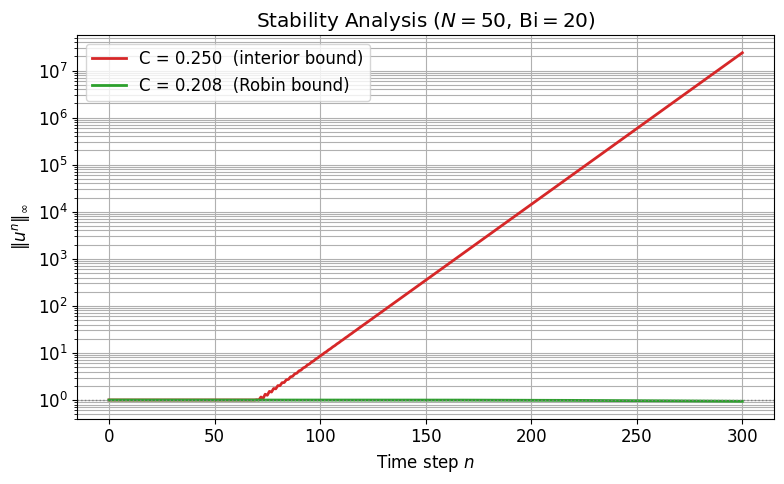

In [79]:
N_stab = 50
h_stab = 1.0 / N_stab
A_stab = laplacian_robin(N_stab, Bi)


# Theoretical bounds
C_interior = 0.25                       # Interior CFL number
C_robin = 1.0 / (4 + 2 * h_stab * Bi)  # Robin CFL number


C_values = [C_interior, C_robin]
labels = [
    f'C = {C_interior:.3f}  (interior bound)',
    f'C = {C_robin:.3f}  (Robin bound)',
]
colors = ['tab:red', 'tab:green']
n_track = 300

u0_stab = -np.ones((N_stab + 1)**2)

fig, ax = plt.subplots(figsize=(8, 5))

for C_val, label, color in zip(C_values, labels, colors):
    dt_val = C_val * h_stab**2
    u = u0_stab.copy()
    norms = [np.max(np.abs(u))]
    for step in range(n_track):
        u = forward_euler(u, A_stab, dt_val)
        norms.append(np.max(np.abs(u)))
        

    ax.semilogy(range(len(norms)), norms, label=label, color=color, lw=2)


ax.axhline(1, color='gray', ls=':', lw=1)
ax.set_xlabel('Time step $n$')
ax.set_ylabel(r'$\|u^n\|_\infty$')
ax.set_title(f'Stability Analysis ($N = {N_stab}$, $\\mathrm{{Bi}} = {Bi:.0f}$)')
ax.legend()
ax.grid(True, which='both')
plt.tight_layout()
plt.show()